In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from xgboost import XGBClassifier, plot_tree
import shap
import eli5
from pdpbox import pdp
from scipy.stats import pearsonr
import warnings
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
warnings.filterwarnings('ignore')

from sklearn.datasets import load_breast_cancer


In [100]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

y = 1 - y

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)


In [101]:
selected_features = []
for column in X_scaled.columns:
    corr, _ = pearsonr(X_scaled[column], y)
    if abs(corr) >= 0.5:
        selected_features.append(column)

# If more than 15 features have |corr| >= 0.5, take top 15 by absolute correlation
if len(selected_features) > 15:
    correlations = [(col, abs(pearsonr(X_scaled[col], y)[0])) for col in X_scaled.columns]
    correlations.sort(key=lambda x: x[1], reverse=True)
    selected_features = [col for col, _ in correlations[:15]]
print("Selected features:", selected_features)
X_selected = X_scaled[selected_features]


Selected features: ['mean radius', 'mean perimeter', 'mean area', 'mean compactness', 'mean concavity', 'mean concave points', 'radius error', 'perimeter error', 'area error', 'worst radius', 'worst perimeter', 'worst area', 'worst compactness', 'worst concavity', 'worst concave points']


In [102]:

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)


# XGBoost model
xgb_model = XGBClassifier(
    max_depth=6,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")

Accuracy: 0.974
Precision: 1.000
Recall: 0.929
F1-Score: 0.963


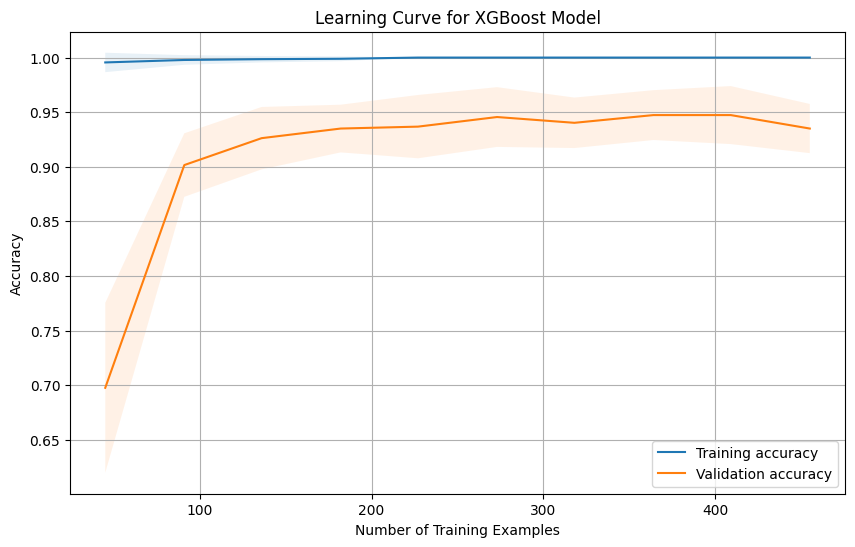

In [103]:
from sklearn.model_selection import learning_curve
train_sizes = np.linspace(0.1, 1.0, 10)

estimator = XGBClassifier(max_depth=6, use_label_encoder=False, eval_metric='logloss', random_state=42)
train_sizes_abs, train_scores, val_scores = learning_curve(
    estimator,
    X_selected,
    y,
    train_sizes=train_sizes,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_abs, train_mean, label='Training accuracy')
plt.plot(train_sizes_abs, val_mean, label='Validation accuracy')
plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, alpha=0.1)
plt.xlabel('Number of Training Examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve for XGBoost Model')
plt.legend()
plt.grid(True)
plt.show()

# The training and validation accuracy scores converge as training size increases

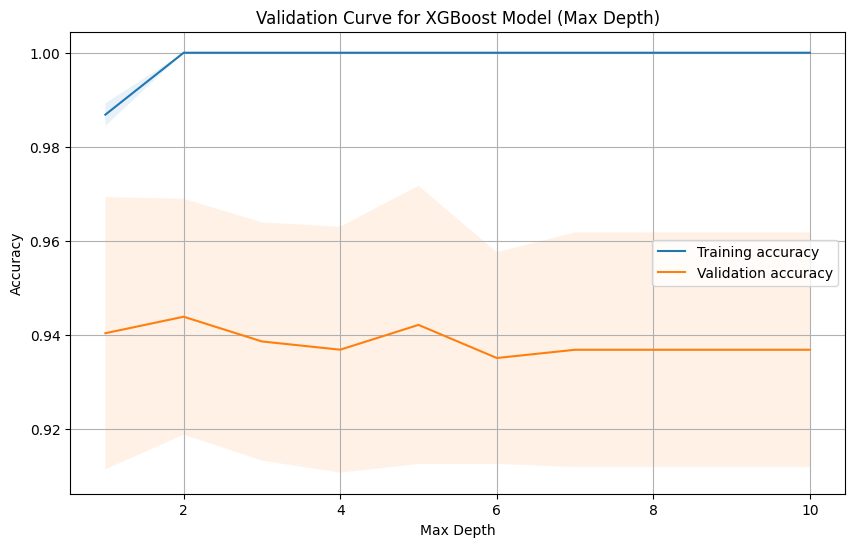

In [104]:
from sklearn.model_selection import validation_curve
param_range = np.arange(1, 11)
estimator = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
train_scores, val_scores = validation_curve(
    estimator,
    X_selected,
    y,
    param_name='max_depth',
    param_range=param_range,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label='Training accuracy')
plt.plot(param_range, val_mean, label='Validation accuracy')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.1)
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Validation Curve for XGBoost Model (Max Depth)')
plt.legend()
plt.grid(True)
plt.show()

# The plot shows that increasing 'max_depth' initially improves both training and validation accuracy. However, after a certain point (around 3-4), increasing it further leads to overfitting

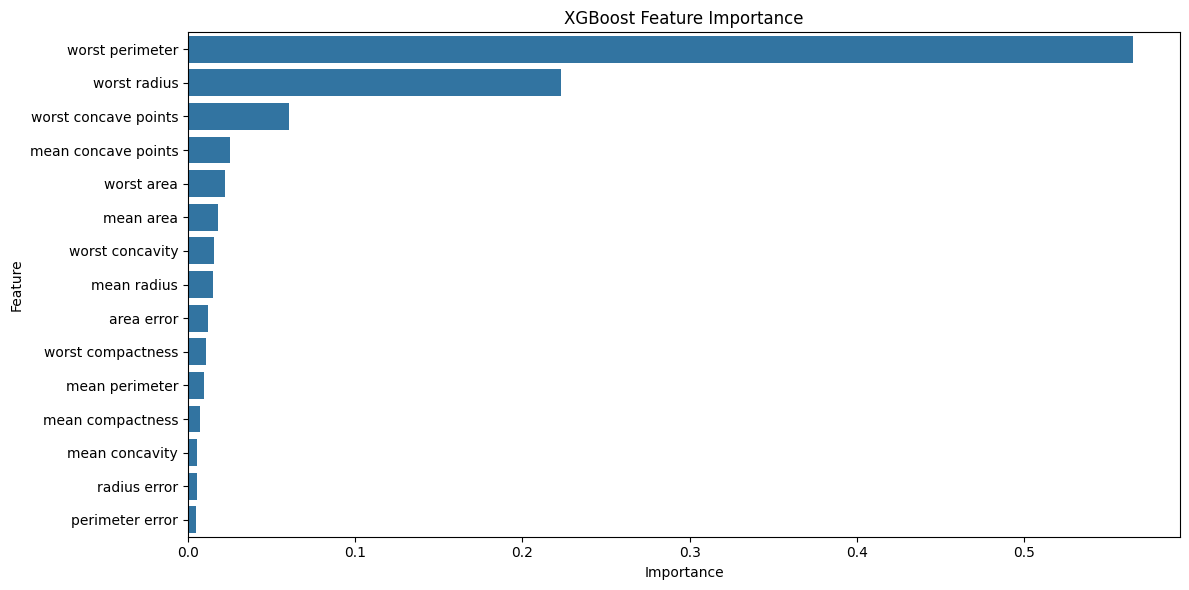


Feature Importance Ranking:
1. worst perimeter: 0.5649
2. worst radius: 0.2230
3. worst concave points: 0.0603
4. mean concave points: 0.0249
5. worst area: 0.0224
6. mean area: 0.0183
7. worst concavity: 0.0155
8. mean radius: 0.0148
9. area error: 0.0122
10. worst compactness: 0.0106
11. mean perimeter: 0.0099
12. mean compactness: 0.0070
13. mean concavity: 0.0057
14. radius error: 0.0055
15. perimeter error: 0.0051


In [105]:
plt.figure(figsize=(12, 6))
xgb_importance = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_selected.columns,
    'Importance': xgb_importance
}).sort_values('Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()
print("\nFeature Importance Ranking:")
for i, (feature, importance) in enumerate(feature_importance_df.values):
    print(f"{i+1}. {feature}: {importance:.4f}")

# 'worst perimeter', 'worst concave points', 'worst radius' are the top 3 most important features. This means that these features have the strongest influence on the model's predictions for breast cancer malignancy.

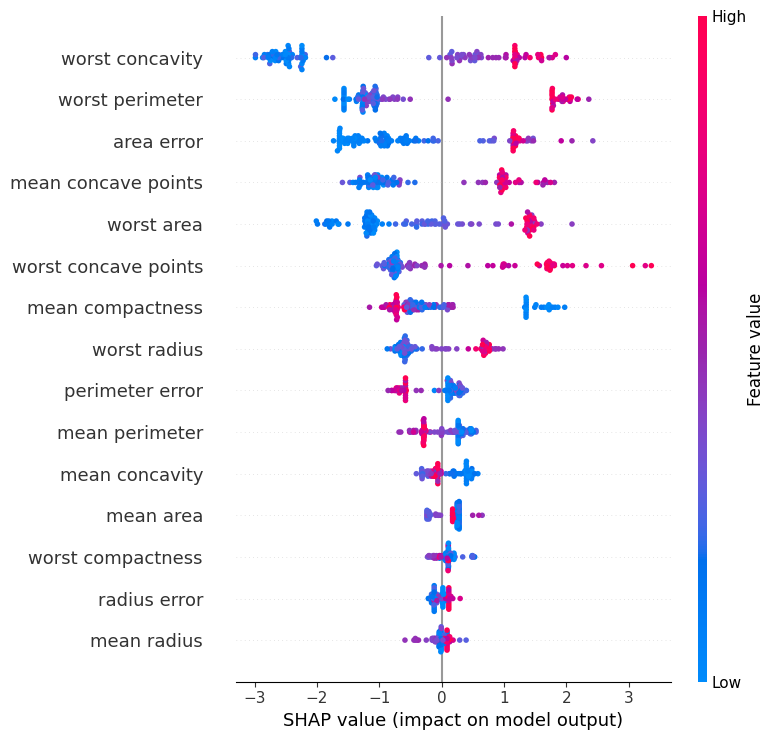

<Figure size 640x480 with 0 Axes>

In [106]:

explainer = shap.Explainer(xgb_model)
shap_values = explainer.shap_values(X_test)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, feature_names=X_selected.columns)
plt.tight_layout()
plt.show()



#  The plot reaffirms the importance of the top features, and indicates that high values of features like 'worst perimeter', 'worst concave points', 'worst radius' generally increase the prediction probability for malignancy (pushing SHAP values to the right), which makes sense given their clinical interpretation.

<Figure size 1000x600 with 0 Axes>

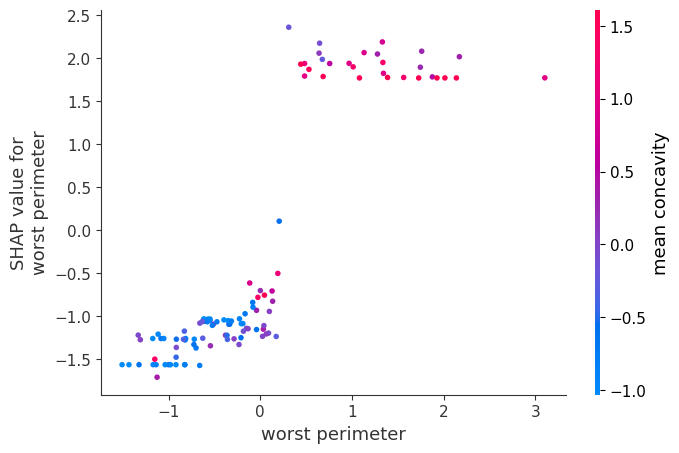

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

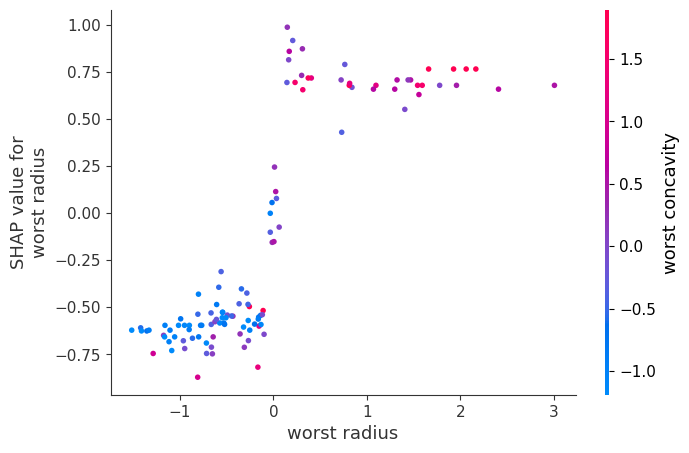

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

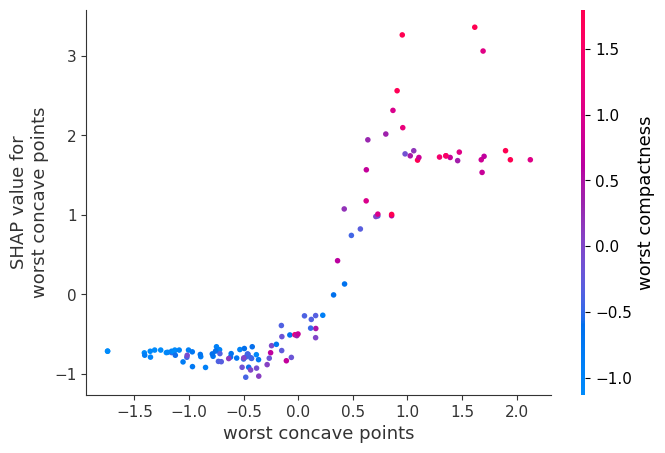

<Figure size 640x480 with 0 Axes>

In [107]:

top_features = feature_importance_df['Feature'].values[:3]
for feature in top_features:
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(feature, shap_values, X_test, feature_names=X_selected.columns)
    plt.tight_layout()
    plt.show()

#  The plot reaffirms the importance of the top features, and indicates that high values of features like 'worst perimeter', 'worst concave points', 'worst radius' generally increase the prediction probability for malignancy (pushing SHAP values to the right), which makes sense given their clinical interpretation.

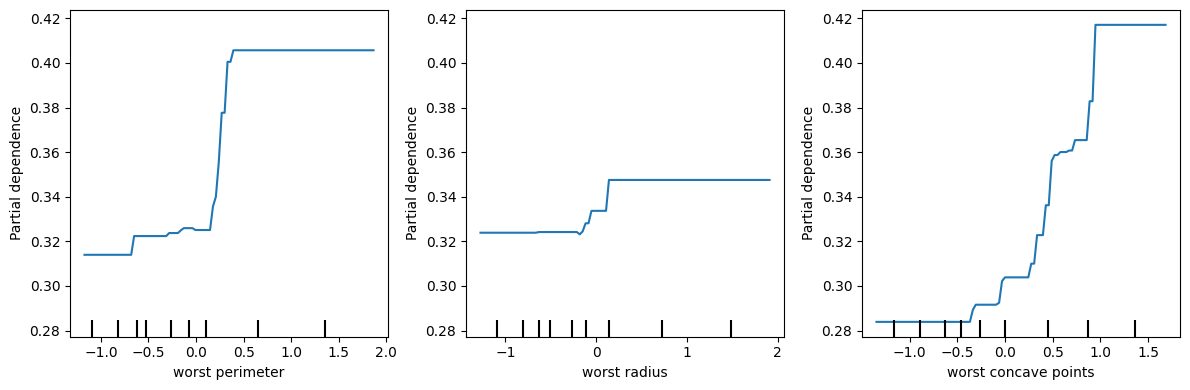

In [108]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=3)
PartialDependenceDisplay.from_estimator(
    xgb_model,
    X_test,
    features=top_features,
    ax=ax
)
plt.tight_layout()
plt.show()

# The plots illustrate the general trend of the feature's impact on prediction. For instance, increasing the 'worst perimeter' generally leads to an increased probability of malignancy. This provides insights into the model's overall behavior concerning these key features.

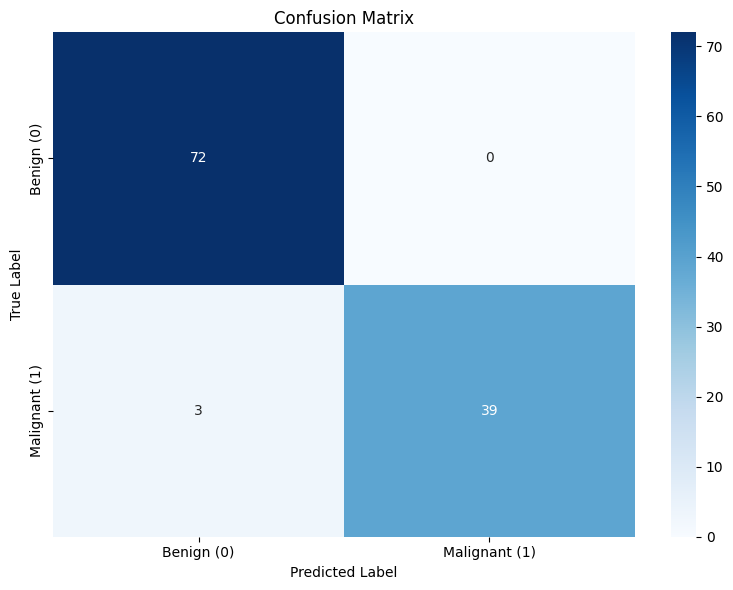

In [109]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign (0)', 'Malignant (1)'],
            yticklabels=['Benign (0)', 'Malignant (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# The confusion matrix helps assess the model's overall accuracy and identify specific areas where it might be making errors


Individual Prediction Explanation
Sample index: 64
True label: Benign
Predicted label: Benign
Prediction probability: Benign: 0.9909, Malignant: 0.0091


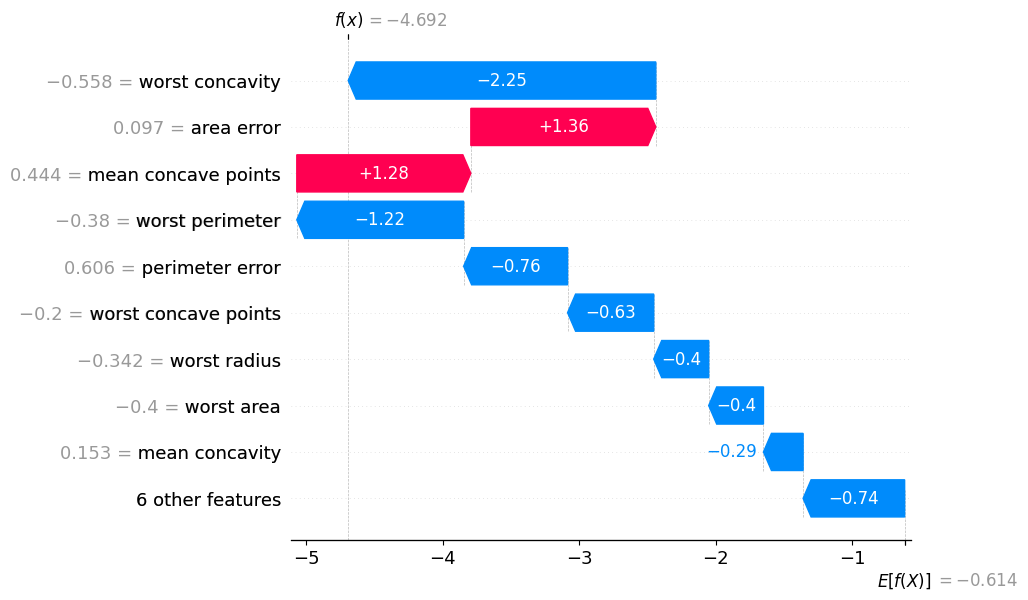

In [110]:

sample_idx = np.random.randint(0, len(X_test))
sample_X = X_test.iloc[[sample_idx]]
sample_y = y_test[sample_idx]
sample_pred = xgb_model.predict(sample_X)[0]
sample_prob = xgb_model.predict_proba(sample_X)[0]

print("\nIndividual Prediction Explanation")
print(f"Sample index: {sample_idx}")
print(f"True label: {'Malignant' if sample_y == 1 else 'Benign'}")
print(f"Predicted label: {'Malignant' if sample_pred == 1 else 'Benign'}")
print(f"Prediction probability: Benign: {sample_prob[0]:.4f}, Malignant: {sample_prob[1]:.4f}")
sample_shap_values = explainer.shap_values(sample_X)[0]
shap.plots.waterfall(shap.Explanation(values=sample_shap_values,
                                        base_values=explainer.expected_value,
                                        data=sample_X.values[0],
                                        feature_names=X_selected.columns))

# The plot helps understand why the model made a specific prediction for a particular data point, making the model more transparent.

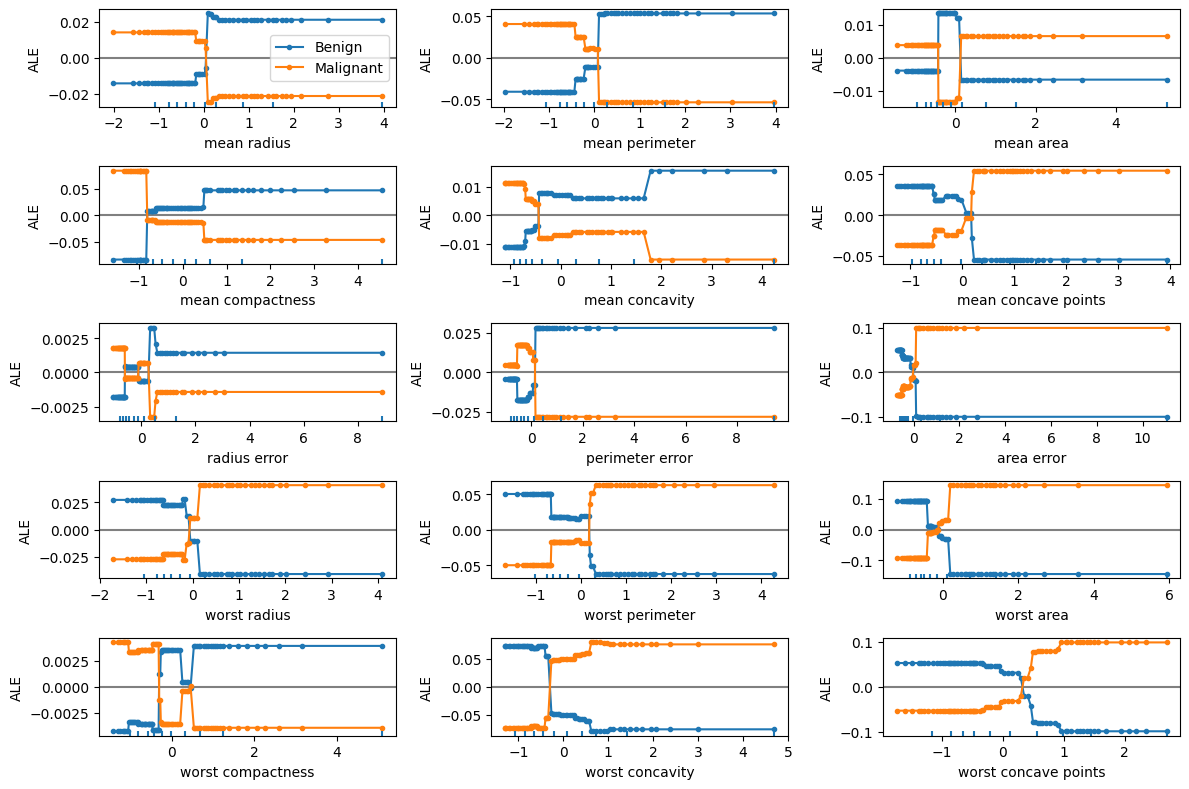

In [123]:
from alibi.explainers import ALE, plot_ale
proba_fun_xgb = xgb_model.predict_proba
proba_ale_xgb = ALE(proba_fun_xgb, feature_names=list(X_selected.columns), target_names=['Benign','Malignant'])
proba_exp_xgb = proba_ale_xgb.explain(X_train.values)
plot_ale(proba_exp_xgb, n_cols=3, fig_kw={'figwidth': 12, 'figheight': 8}, sharey=True)
plt.show()

# These plots illustrate how the model's prediction changes as a feature's value varies, averaged over other features' values. They help understand complex feature interactions and how the feature's impact might vary in different parts of the feature space.

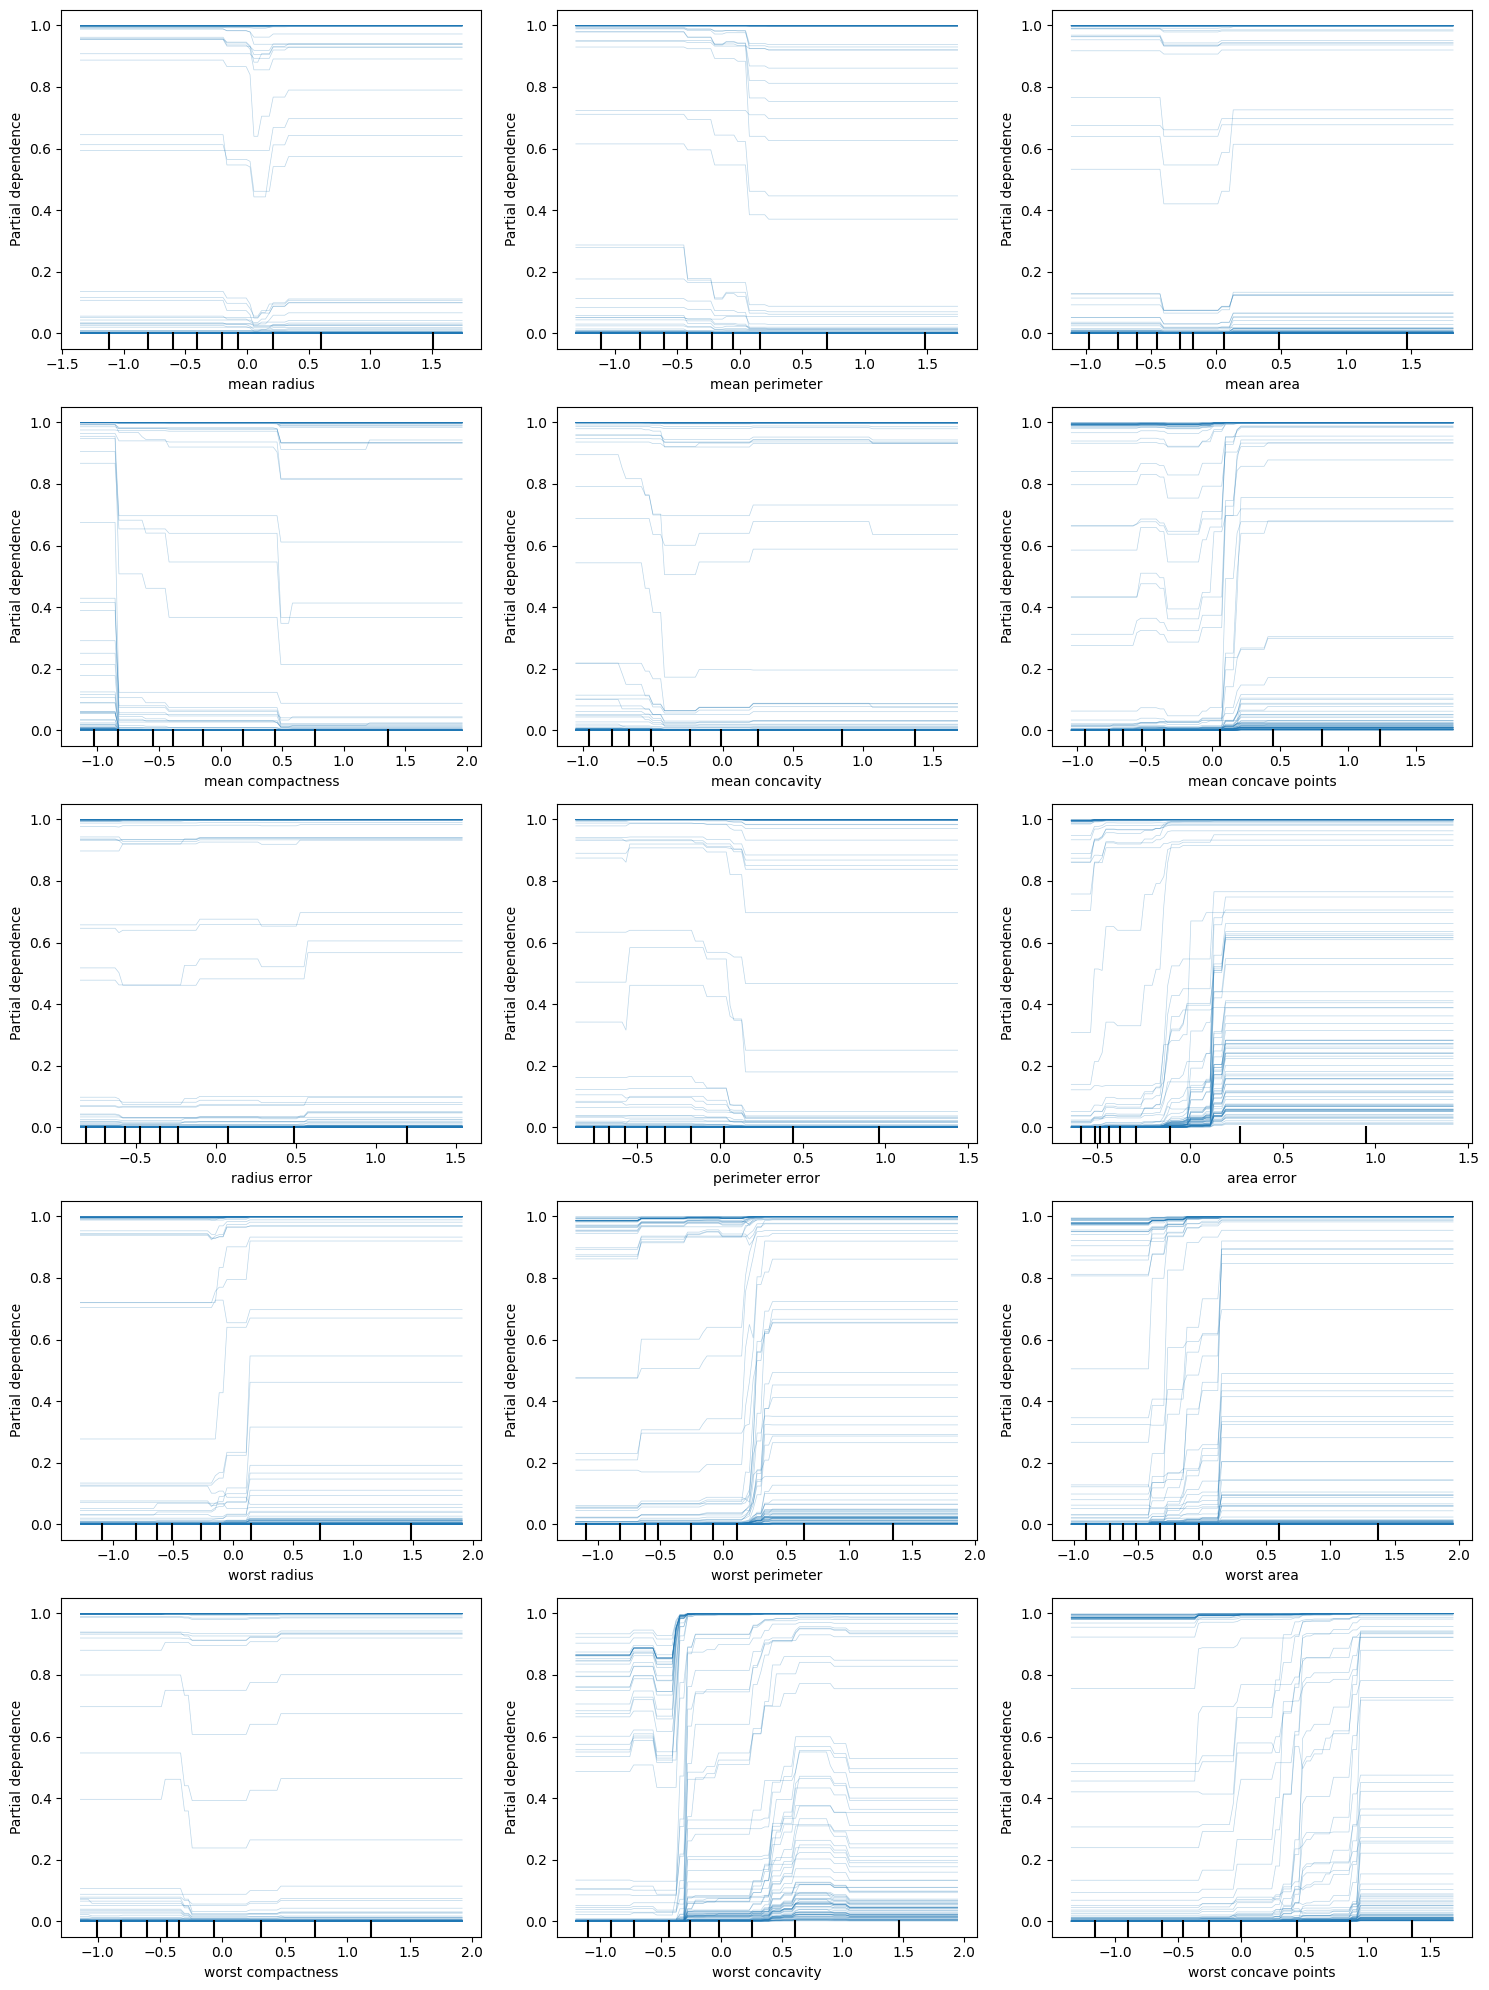

In [139]:
from sklearn.inspection import PartialDependenceDisplay


n_features = len(selected_features)
n_cols = 3
n_rows = math.ceil(n_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for i, feature in enumerate(selected_features):
    PartialDependenceDisplay.from_estimator(
        xgb_model, X_test, features=[feature], kind='individual', ax=axes[i]
    )


for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# ICE plots provide more individual-level insights compared to PD plots, revealing potential heterogeneities in feature effects.

In [141]:
import lime
import lime.lime_tabular

In [143]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=selected_features,
    class_names=data.target_names.tolist(),
    mode='classification',
    discretize_continuous=True
)

In [152]:
i = 0
exp = explainer.explain_instance(
    data_row=X_test.iloc[i].values,
    predict_fn=xgb_model.predict_proba,
    num_features=len(selected_features)
)

exp.show_in_notebook(show_table=True, show_all=False)

# Prediction: The model is highly confident that the sample is malignant (probability: 100%).
#Feature Contributions: The features 'worst perimeter', 'worst concave points', and 'worst radius' have the largest positive contributions, indicating that their higher values strongly influenced the model's prediction towards malignancy.
#Feature Values: You can observe the actual values of these features for the selected instance, which further contextualizes the prediction.